In [1]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import RobertaTokenizer, RobertaForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
import os 

c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Grote_data_cleaned.xlsx")
df = pd.read_excel(file_path)

# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# Clean text
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove patterns like 'a)', 'b)', etc.
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove patterns like '1.', '2.', etc.
    text = re.sub(r'\b\d+\)\b', '', text)  # Remove patterns like '1)', '2)', etc.
    text = re.sub(r'\b[i]+[.)]\b', '', text, flags=re.IGNORECASE)  # Remove patterns like 'i.', 'ii.', 'i)', etc.
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and trim
    text = re.sub(r'\b\d+[.)]\s*', '', text) # Remove numeric list markers like 1., 2. or 1) 2)
    text = re.sub(r'\b[ivxlcdm]+\s*[.)]\s*', '', text, flags=re.IGNORECASE)# Remove roman numerals like i. ii. iii. or i) ii) iii)
    return text

# df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)
df["clean_text"] = (df["question"]).apply(clean_text) 

# Group by 'clean_text' and count unique themes
duplicates_with_diff_themes = df.groupby("clean_text")["theme"].nunique().reset_index()

# Filter rows where the number of unique themes is greater than 1
duplicates_with_diff_themes = duplicates_with_diff_themes[duplicates_with_diff_themes["theme"] > 1]

# Merge back with the original dataframe to get all rows with these 'clean_text'
filtered_df = df[df["clean_text"].isin(duplicates_with_diff_themes["clean_text"])]
# Exclude rows with these 'clean_text' from the original dataframe
df = df[~df["clean_text"].isin(duplicates_with_diff_themes["clean_text"])]

# ✅ Now: drop rare themes using original theme names
theme_counts = df["theme"].value_counts()
valid_themes = theme_counts[theme_counts >= 2].index
df = df[df["theme"].isin(valid_themes)]

# ✅ Recompute label encoding AFTER filtering
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}
df["theme_id"] = df["theme"].map(theme_to_id)

print("All theme_ids:", sorted(df["theme_id"].unique()))
print("num_labels:", df["theme_id"].nunique())

#amount of rows 
print(f"Number of rows after filtering: {len(df)}")

C:\Users\corne\AppData\Local\Temp\ipykernel_34016\2384651969.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)


All theme_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
num_labels: 37
Number of rows after filtering: 22915


In [3]:
print(df[["question", "clean_text"]].tail())

                                                question  \
26058  2. Werd de opdracht aan de dienst Vastgoedtran...   
26059                 Zo niet, wanneer zal dat gebeuren?   
26060          3. Hoe ver staat het met de aanbesteding?   
26061  4. Wat is de verdere planning en timing van he...   
26062  5. Dit betreft slechts een eerste stuk van de ...   

                                              clean_text  
26058  Werd de opdracht aan de dienst Vastgoedtransac...  
26059                 Zo niet, wanneer zal dat gebeuren?  
26060             Hoe ver staat het met de aanbesteding?  
26061  Wat is de verdere planning en timing van het p...  
26062  Dit betreft slechts een eerste stuk van de vol...  


In [4]:
# ✅ 5. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_text"].tolist(), df["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df["theme_id"]
)

from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create a small DataFrame from train lists
train_df = pd.DataFrame({
    "clean_text": train_texts,
    "theme_id": train_labels
})

# Compute class counts and use median as balancing target
theme_counts = train_df["theme_id"].value_counts()
median_count = theme_counts.median()

# Define strategy: only oversample underrepresented classes
sampling_strategy = {
    theme: int(median_count)
    for theme in theme_counts.index
    if theme_counts[theme] < median_count
}

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[["clean_text"]], train_df["theme_id"])

# Extract oversampled train lists
train_texts_resampled = X_resampled["clean_text"].tolist()
train_labels_resampled = y_resampled.tolist()

from collections import Counter
print("Class distribution after oversampling:", Counter(train_labels_resampled))


# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "GroNLP/bert-base-dutch-cased"              # aanpassen naar welk model je wilt evaluaten !!!!
tokenizer = BertTokenizer.from_pretrained(model_name)     # aanpassen naar welk model je wilt evaluaten !!!!

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts_resampled, train_labels_resampled, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

Class distribution after oversampling: Counter({15: 4841, 4: 1521, 9: 1455, 26: 1066, 12: 972, 6: 776, 21: 742, 20: 635, 0: 602, 16: 573, 28: 560, 14: 539, 8: 449, 1: 398, 17: 343, 11: 314, 22: 281, 23: 261, 7: 233, 35: 233, 18: 233, 19: 233, 32: 233, 29: 233, 24: 233, 5: 233, 31: 233, 13: 233, 2: 233, 30: 233, 25: 233, 3: 233, 27: 233, 10: 233, 36: 233, 33: 233, 34: 233})


LOAD THE MODEL YOU WANT TO EVALUATE FROM KUL DRIVE!!

In [5]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 20755
Test dataset size: 4583


In [6]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "C:/Users/corne/OneDrive - KU Leuven/Thesis/Working Code/SAVED-Models/GroNLP/Run_2025-04-07_23-42"        # ook naam tokenize in cel hierboven aanpassen !!!
#model_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\Code\BERT_Classifiers\results\checkpoint-13790"


model = BertForSequenceClassification.from_pretrained(model_path).cuda()
print(model.config._name_or_path)


C:/Users/corne/OneDrive - KU Leuven/Thesis/Working Code/SAVED-Models/GroNLP/Run_2025-04-07_23-42


In [7]:
training_args = TrainingArguments(output_dir="./results", per_device_eval_batch_size=8)

trainer = Trainer(
    model=model,
    args=training_args
)

In [8]:
predictions = trainer.predict(test_dataset)


100%|██████████| 573/573 [01:17<00:00,  7.39it/s]


In [9]:
lengthDataset = len(test_dataset)
print("Length of test dataset:", lengthDataset)

Length of test dataset: 4583


HANDLE UNKNOWNS and save those predictions

In [10]:
# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (1st Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label


Dynamic Threshold: 0.41512388348579404


In [11]:
# Create list of results
results = [
    "Unknown" if pred == "Unknown"
    else "Correct" if id_to_theme[true_label] == pred
    else "Incorrect"
    for true_label, pred in zip(test_labels, predicted_labels)
]

# Create DataFrame with results column
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels,
    "Result": results
})

# Save to Excel
output_df.to_excel("test.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")


✅ Model Training Completed! Predictions saved.


EVALATION

In [12]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 75 / 4583 (1.64%)


C:\Users\corne\AppData\Local\Temp\ipykernel_34016\648252202.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


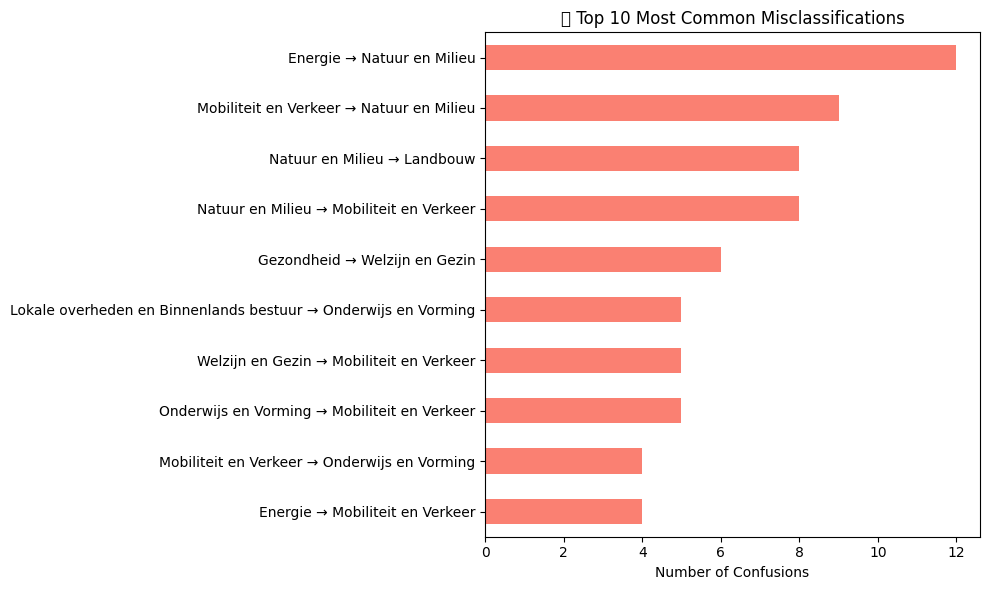

In [13]:
import matplotlib.pyplot as plt


# ✅ Create a DataFrame of misclassifications (excluding Unknowns)
df_misclassified = output_df[
    (output_df["Result"] == "Incorrect") &
    (output_df["Predicted_Theme"] != "Unknown")
]

# ✅ Group by (True_Theme, Predicted_Theme) and count occurrences
top_confusions = (
    df_misclassified
    .groupby(["True_Theme", "Predicted_Theme"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# ✅ Convert MultiIndex to string for clean plotting
top_confusions_plot = top_confusions.copy()
top_confusions_plot.index = [f"{true} → {pred}" for true, pred in top_confusions_plot.index]

# ✅ Plot
plt.figure(figsize=(10, 6))
top_confusions_plot.plot(kind="barh", color="salmon")
plt.xlabel("Number of Confusions")
plt.title("🔍 Top 10 Most Common Misclassifications")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


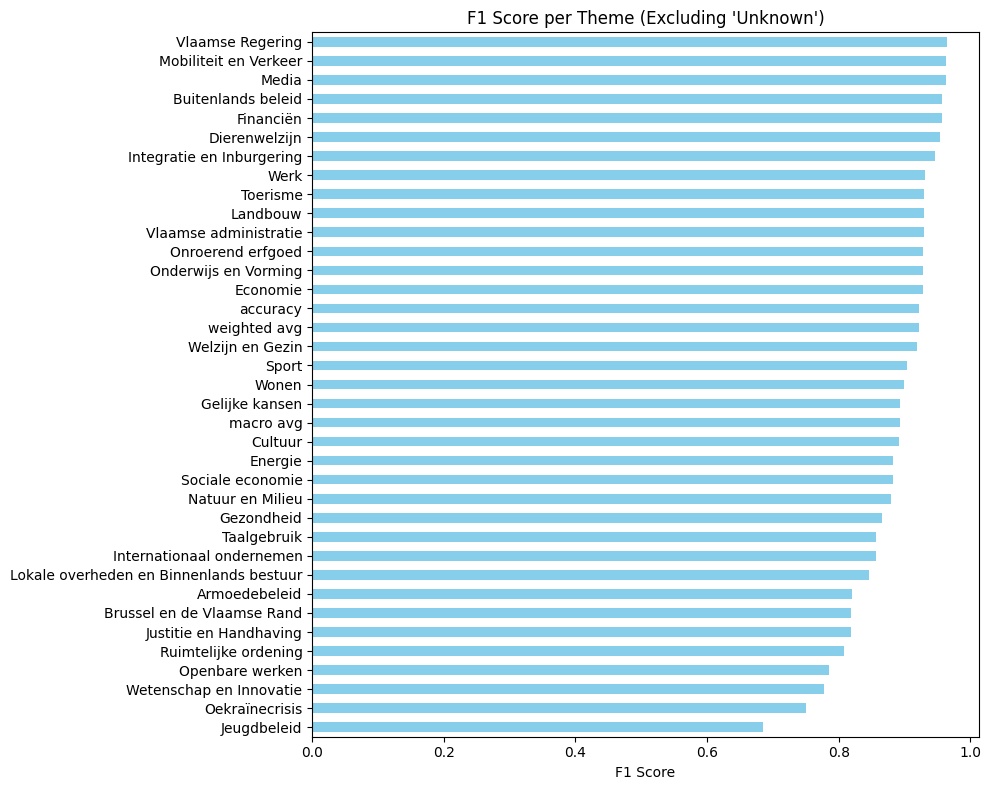

In [14]:
# for clean per-class evaluation, you want to exclude "Unknown" from both True and Predicted values:

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# ✅ Filter out 'Unknown' predictions for proper label matching
filtered_df = output_df[output_df["Predicted_Theme"] != "Unknown"].copy()

# ✅ Encode using only the matching rows
le = LabelEncoder()
true_encoded = le.fit_transform(filtered_df["True_Theme"])
pred_encoded = le.transform(filtered_df["Predicted_Theme"])

# ✅ Get classification report
report = classification_report(
    true_encoded,
    pred_encoded,
    target_names=le.classes_,
    output_dict=True
)

# ✅ Visualize F1 per class
import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).transpose().sort_values("f1-score")
df_report[:-3]["f1-score"].plot(kind="barh", figsize=(10, 8), color="skyblue")
plt.title("F1 Score per Theme (Excluding 'Unknown')")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


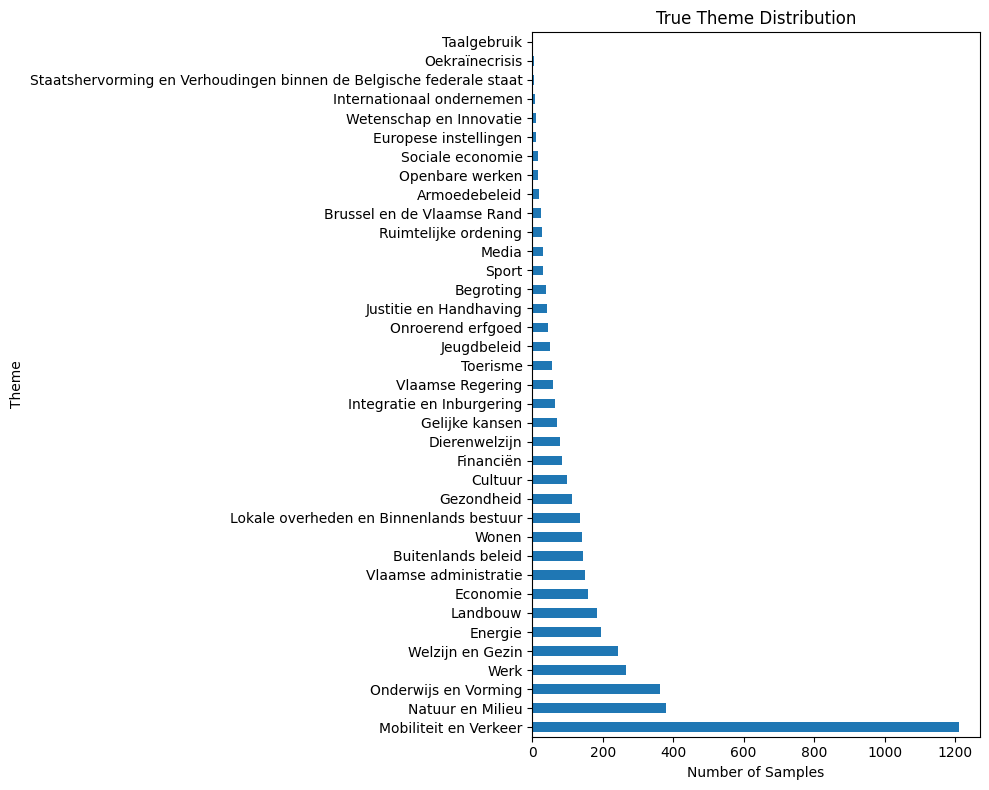

In [15]:
output_df["True_Theme"].value_counts().plot(kind="barh", figsize=(10, 8))

plt.title("True Theme Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [16]:
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids


from sklearn.metrics import classification_report

all_labels = sorted(id_to_theme.keys())  # [0, 1, 2, ..., 34]
all_names = [id_to_theme[i] for i in all_labels]

print(classification_report(y_true, y_pred, labels=all_labels, target_names=all_names))

                                                                     precision    recall  f1-score   support

                                              Vlaamse administratie       0.98      0.89      0.93       150
                                                            Cultuur       0.88      0.87      0.87        99
                                                   Vlaamse Regering       1.00      0.93      0.96        58
                                                      Armoedebeleid       0.84      0.80      0.82        20
                                                   Natuur en Milieu       0.86      0.88      0.87       381
                                                        Jeugdbeleid       0.82      0.54      0.65        50
                                                            Energie       0.91      0.84      0.87       194
                                               Ruimtelijke ordening       0.84      0.75      0.79        28
                  

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
true_labels = [id_to_theme[label] for label in test_labels]
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9075
Precision: 0.9230
Recall: 0.9075
F1-Score: 0.9139


c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


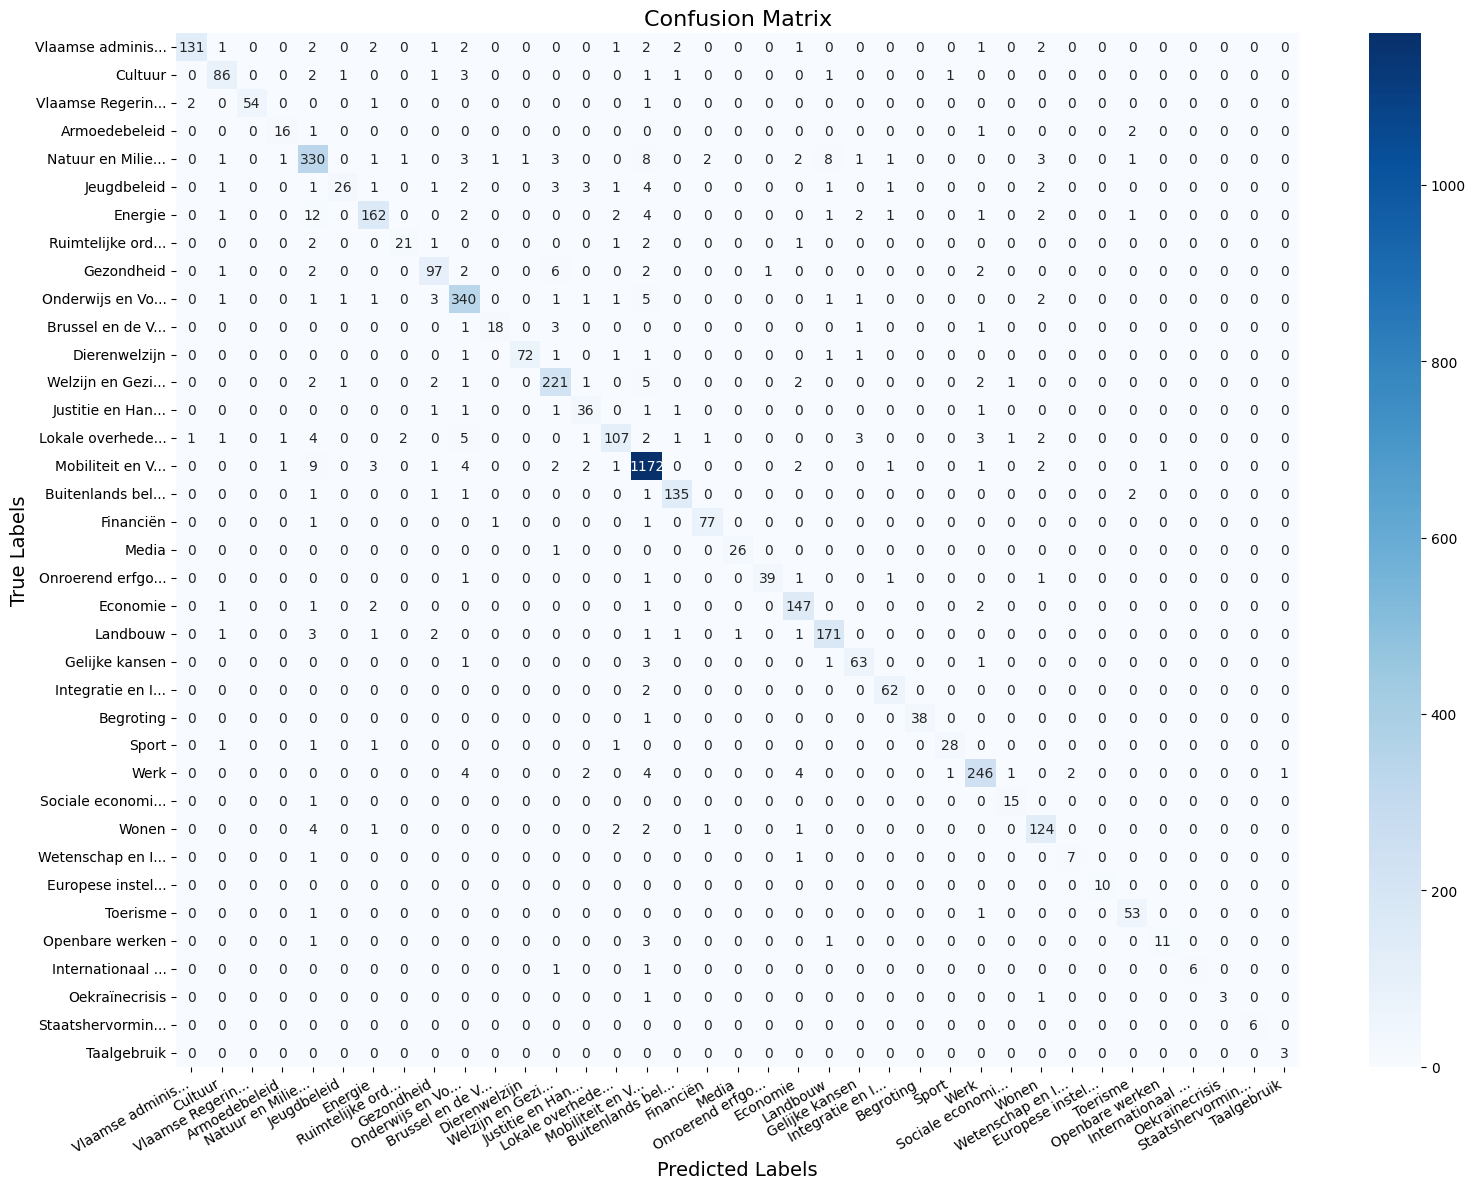

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [19]:
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [20]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize input
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt")  
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}  # Move to GPU if available

    # Forward pass to get attention scores and logits
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    attentions = outputs.attentions  # Extract attention scores
    logits = outputs.logits  # Model prediction scores

    predicted_class_id = logits.argmax(dim=1).item()  # Get predicted class ID
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")  # Convert ID to actual class name

    return attentions, predicted_class_id, predicted_class_name


test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Landbouw (ID: 21)
🔍 Total Attention Layers Extracted: 12


Weighted ROC AUC: 0.9806


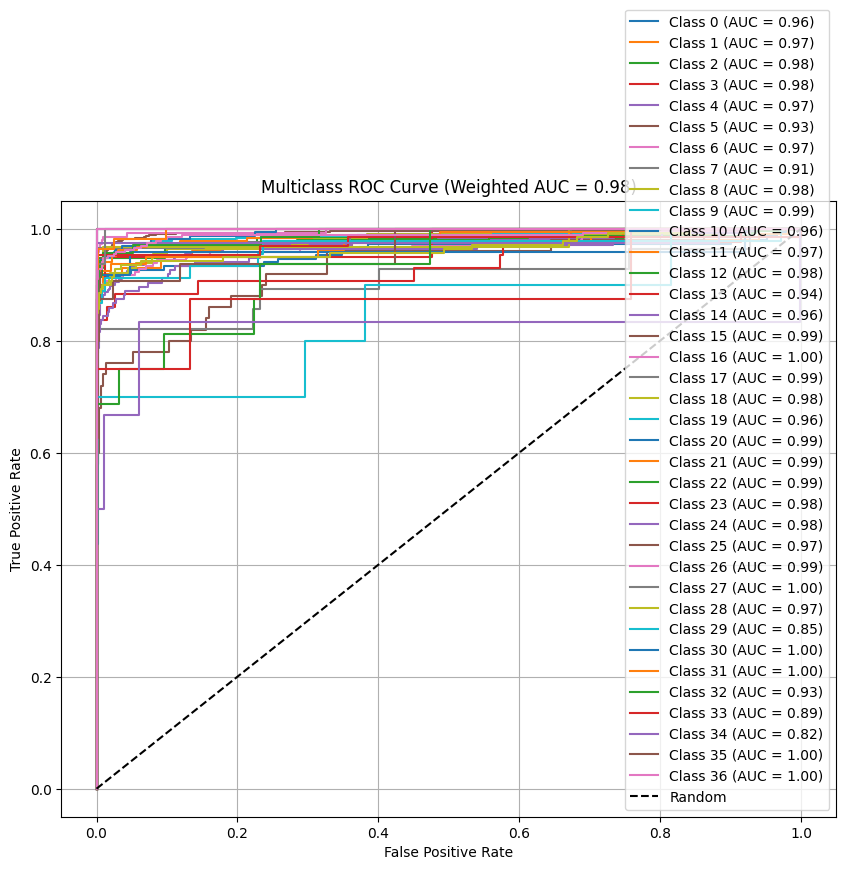

In [21]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on test set

logits = predictions.predictions
y_true = predictions.label_ids
y_score = logits  # raw logits

# Get number of classes
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

from sklearn.utils.class_weight import compute_class_weight

# Calculate support (samples per class)
support = np.bincount(y_true)
total = support.sum()

# Weighted AUC
weighted_auc = sum(roc_auc[i] * support[i] for i in range(n_classes)) / total
print(f"Weighted ROC AUC: {weighted_auc:.4f}")


plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted AUC = {:.2f})".format(weighted_auc))
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [22]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd()
project_root = os.path.dirname(script_dir)

data_folder = os.path.join(project_root, "Data")
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

# Recreate train-test split to match training
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["theme"]
)

# ✅ 2. Load fine-tuned model and tokenizer
model_path = "results/checkpoint-38233"  # Adjust as needed
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Combine context and question for model input
df_test["context_question"] = df_test["context"].astype(str) + " " + df_test["question"].astype(str)


# ✅ 3. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


NameError: name 'AutoTokenizer' is not defined

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

# ✅ 4. Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.base_model(**inputs)  # Safer than model.bert
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# ✅ 5. Sample and embed from test set
sample_df = pd.DataFrame({
    "clean_text": test_texts,
    "theme_id": test_labels
}).sample(n=2000, random_state=42)


embeddings = []

print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["clean_text"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# ✅ 6. UMAP dimensionality reduction
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# ✅ 7. Plot UMAP
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme_id"])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of mBERT Embeddings (After Fine-tuning on Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()
